# We love shrooms

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import StandardScaler

In [31]:
# load the dataset
path = kagglehub.dataset_download("uciml/mushroom-classification")
mushroom = pd.read_csv(path + "/mushrooms.csv")
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [32]:
# No missing values in the dataset, do other things

print("--- Data Type Counts ---")
print(mushroom.dtypes.value_counts())
print("\n" + "="*40 + "\n")

categorical_cols = mushroom.select_dtypes(include=['object']).columns.tolist()
print(f"--- Categorical Attributes ({len(categorical_cols)}) ---")
print(*categorical_cols, sep='\n')
print("\n" + "="*40 + "\n")

numerical_cols = mushroom.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"--- Numerical or Binary Attributes({len(numerical_cols)}) ---")
print(*numerical_cols, sep='\n')

--- Data Type Counts ---
object    23
Name: count, dtype: int64


--- Categorical Attributes (23) ---
class
cap-shape
cap-surface
cap-color
bruises
odor
gill-attachment
gill-spacing
gill-size
gill-color
stalk-shape
stalk-root
stalk-surface-above-ring
stalk-surface-below-ring
stalk-color-above-ring
stalk-color-below-ring
veil-type
veil-color
ring-number
ring-type
spore-print-color
population
habitat


--- Numerical or Binary Attributes(0) ---



In [33]:

# Model Development


X = mushroom.drop(columns=['class'])
y = mushroom['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_feats = X_train.select_dtypes(include=['object']).columns.tolist()
categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_popular", # Impute missing categorical values with a constant string
            SimpleImputer(strategy="most_frequent"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

# 
numeric_feats = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_preprocessor = Pipeline(
    steps=[
        (
            "imputation_mean", # Impute missing numerical values with the mean
            SimpleImputer(strategy="mean"),
        ),
        ("scaling", StandardScaler()),
    ]
)

pipe = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('categorical', categorical_preprocessor, categorical_feats),
            ('numerical', numeric_preprocessor, numeric_feats)
        ]),

     ),
    ('classifier', None)  # Placeholder for the model to be added later
])

# Define the parameter grids for different models
# Note: <step>__<parameter_name> is used to specify parameters for the classifier step in the pipeline
param_grid = [
    {
        'classifier': [LogisticRegression(random_state=42, max_iter=1000)],
        'classifier__C': [0.1, 1.0, 10],
        'classifier__solver': ['liblinear']
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10, None]
    },
    {
        'classifier': [SVC(random_state=42, probability=True)],
        'classifier__C': [0.1, 1.0, 10],
        'classifier__gamma': ['scale', 'auto']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        'classifier': [DecisionTreeClassifier(random_state=42)],
        'classifier__max_depth': [5, 10, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    {
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
    }

]

# Run GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# What's the best model?
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best Model:, {grid_search.best_params_}")
print (f"Best score:, {grid_search.best_score_:.4f}")
pipe

Best Model:, {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best score:, 1.0000


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_popular',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color', 'bruises',
                                                   'odor', 'gill-attachment',
                                                   'gill-spacing', 'gill-size',
                                                   'gill-color', 'stalk-shape',
                                                   'stalk-root',
                                                   'stalk-surface-above-ring',
                                                   'stalk-surface-below-ring',
                                                   'stalk-color-above-ring',
                                                   'stalk-color-below-ring',
                                                   'veil-type', 'veil-color',
                                                   'ring-number', 'ring-type',
                                                   'spore-print-color',
                                                   'population', 'habitat']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  [])])),
                ('classifier', None)])

In [34]:
# Evaluation on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print ("The winner model is: ", grid_search.best_estimator_.named_steps['classifier'].__class__.__name__)
print ("with params: ", grid_search.best_params_)
print("\n" + "="*40 + "\n")
print("Test Set Classification Report:")
print (classification_report(y_test, y_pred))

The winner model is:  RandomForestClassifier
with params:  {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': 10, 'classifier__n_estimators': 100}


Test Set Classification Report:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



Let's examine the feature importances from our best model, the RandomForestClassifier. This can help us understand which features are most influential in the model's predictions. An unusually high importance for a single feature might be a red flag for data leakage, especially if that feature is directly or indirectly related to the target variable in a way that wouldn't exist in a real-world prediction scenario.

In [35]:
# Top n models
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
n = 5
print(f"Top {n} Models:")
for i, row in results.tail(n).iterrows(): 
    #print(f"Rank {i+1}:")
    print(f"Model: {row['params']['classifier'].__class__.__name__}")
    print(f"Mean Test Score on k-Fold CV: {row['mean_test_score']:.4f}")
    
    filterd_params = {k.replace('classifier__', ''): v for k, v in row['params'].items() if k != 'classifier'}
    print(f"Parameters: {filterd_params}") 
    print("-" * 30)


Top 5 Models:
Model: RandomForestClassifier
Mean Test Score on k-Fold CV: 0.9898
Parameters: {'max_depth': 5, 'n_estimators': 100}
------------------------------
Model: GaussianNB
Mean Test Score on k-Fold CV: 0.9842
Parameters: {'var_smoothing': 1e-07}
------------------------------
Model: SVC
Mean Test Score on k-Fold CV: 0.9783
Parameters: {'C': 0.1, 'gamma': 'auto'}
------------------------------
Model: GaussianNB
Mean Test Score on k-Fold CV: 0.9718
Parameters: {'var_smoothing': 1e-08}
------------------------------
Model: GaussianNB
Mean Test Score on k-Fold CV: 0.9541
Parameters: {'var_smoothing': 1e-09}
------------------------------


## Visualize Performance of Naive Bayes (Worst Model)

The worst model is:  GaussianNB
with params:  {'var_smoothing': 1e-09}
Achiving accuracy:  0.9618461538461538
              precision    recall  f1-score   support

           e       1.00      0.93      0.96       842
           p       0.93      1.00      0.96       783

    accuracy                           0.96      1625
   macro avg       0.96      0.96      0.96      1625
weighted avg       0.96      0.96      0.96      1625



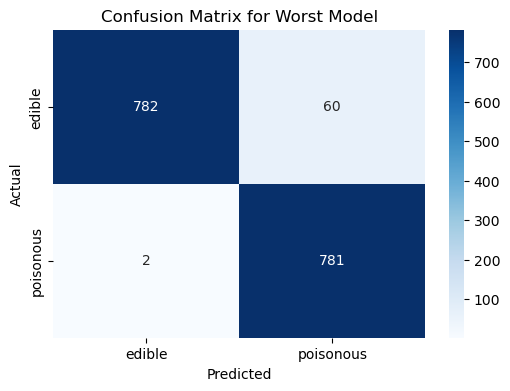

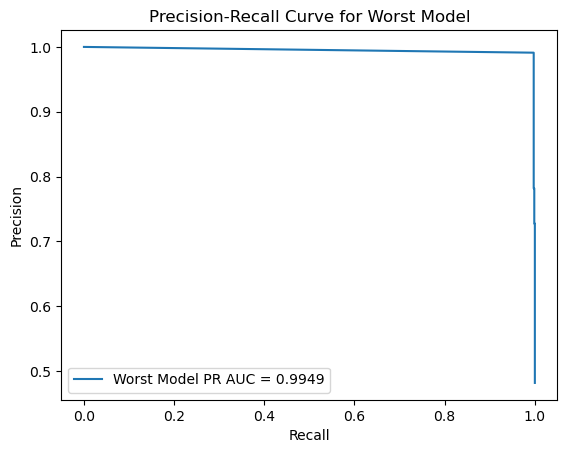

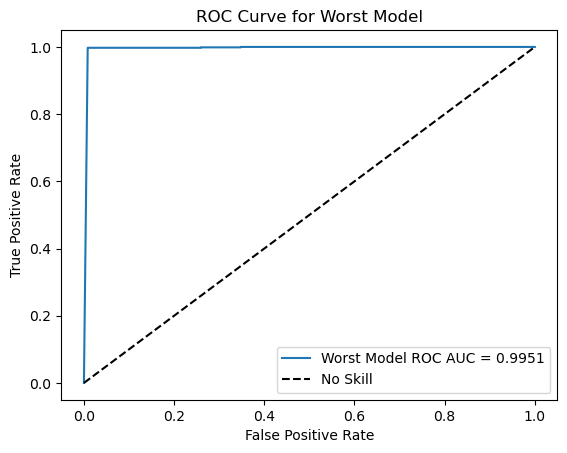

In [36]:
# Retrieve the worst model
from sklearn.metrics import roc_curve, precision_recall_curve, auc
results = pd.DataFrame(grid_search.cv_results_)
worst_index = results['mean_test_score'].idxmin()
worst_model_params = results.loc[worst_index, 'params']
worst_model = pipe.set_params(**worst_model_params)
worst_model.fit(X_train, y_train)
print ("The worst model is: ", worst_model.named_steps['classifier'].__class__.__name__)
print ("with params: ", {k.replace('classifier__', ''): v for k, v in worst_model_params.items() if k != 'classifier'})
print ("Achiving accuracy: ", accuracy_score(y_test, worst_model.predict(X_test)))

print (classification_report(y_test, worst_model.predict(X_test)))

# Confusion Matrix for the worst model
worst_y_pred = worst_model.predict(X_test)
cm = confusion_matrix(y_test, worst_y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['edible', 'poisonous'], yticklabels=['edible', 'poisonous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Worst Model')
plt.show()

# Precision-Recall Curve for the worst model
worst_precision, worst_recall, worst_thresholds = precision_recall_curve(y_true=y_test.map({'e':0, 'p':1}), probas_pred=worst_model.predict_proba(X_test)[:, 1])
worst_pr_auc = auc(worst_recall, worst_precision)  
plt.figure()
plt.plot(worst_recall, worst_precision, label=f'Worst Model PR AUC = {worst_pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Worst Model')
plt.legend()
plt.show()


# ROC Curve for the worst model
worst_fpr, worst_tpr, _ = roc_curve(y_true=y_test.map({'e':0, 'p':1}), y_score=worst_model.predict_proba(X_test)[:, 1])
worst_roc_auc = auc(worst_fpr, worst_tpr)
plt.figure()
plt.plot(worst_fpr, worst_tpr, label=f'Worst Model ROC AUC = {worst_roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Worst Model')
plt.legend()
plt.show()

# Association Rules

In [37]:
# TODO: see if there is an easy pattern to recognize which shrooms can be eaten
# Want to find characteristic rules to better differentiate edible vs poisonous shrooms
# support = how frequently the itemset appears in the dataset
# confidence = likelihood that the rule is correct
# Lift = how much more likely the consequent is, given the antecedent, than without the antecedent
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(pd.get_dummies(mushroom), min_support=0.4, use_colnames=True) # Get frequent itemsets from a one-hot encoded dataframe
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)
# rules 
# See ones where consequents contain 'class_e' or 'class_p'
rules.loc[rules['consequents'].apply(lambda x: 'class_e' in x or 'class_p' in x)] # Inside bracket is true if edible type is found in "consequents"


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(odor_n),(class_e),0.434269,0.517971,0.419498,0.965986,1.864941,1.0,0.194559,14.171640,0.819807,0.787431,0.929437,0.887936
3,(gill-attachment_f),(class_e),0.974151,0.517971,0.494338,0.507455,0.979697,1.0,-0.010244,0.978649,-0.444971,0.495435,-0.021817,0.730914
4,(gill-size_b),(class_e),0.690793,0.517971,0.482521,0.698503,1.348536,1.0,0.124710,1.598785,0.835864,0.664407,0.374525,0.815031
7,(stalk-surface-above-ring_s),(class_e),0.637125,0.517971,0.448055,0.703246,1.357692,1.0,0.118043,1.624336,0.726023,0.633705,0.384364,0.784132
8,(stalk-surface-below-ring_s),(class_e),0.607582,0.517971,0.418513,0.688817,1.329836,1.0,0.103803,1.549019,0.632050,0.591922,0.354430,0.748401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6021,(veil-type_p),"(class_p, ring-number_o, veil-color_w, gill-at...",1.000000,0.454948,0.454948,0.454948,1.000000,1.0,0.000000,1.000000,0.000000,0.454948,0.000000,0.727474
6022,(ring-number_o),"(class_p, veil-type_p, veil-color_w, gill-atta...",0.921713,0.466027,0.454948,0.493590,1.059145,1.0,0.025405,1.054429,0.713306,0.487728,0.051619,0.734909
6023,(veil-color_w),"(class_p, veil-type_p, ring-number_o, gill-att...",0.975382,0.454948,0.454948,0.466431,1.025240,1.0,0.011200,1.021521,1.000000,0.466431,0.021067,0.733216
6024,(gill-spacing_c),"(class_p, veil-type_p, ring-number_o, veil-col...",0.838503,0.467750,0.454948,0.542572,1.159962,1.0,0.062739,1.163571,0.853903,0.534413,0.140577,0.757602


# Visualization


In [38]:
# TODO: Chi-Squared test of independence: see if there is a significant association between 'odor' and 'class'

Top 10 Feature Importances:
                                    feature  importance
27                      categorical__odor_n    0.150306
36                 categorical__gill-size_n    0.073059
24                      categorical__odor_f    0.060525
35                 categorical__gill-size_b    0.051974
61  categorical__stalk-surface-below-ring_k    0.050576
96         categorical__spore-print-color_h    0.046373
57  categorical__stalk-surface-above-ring_k    0.037063
37                categorical__gill-color_b    0.034470
94                 categorical__ring-type_p    0.032142
20                   categorical__bruises_f    0.029842


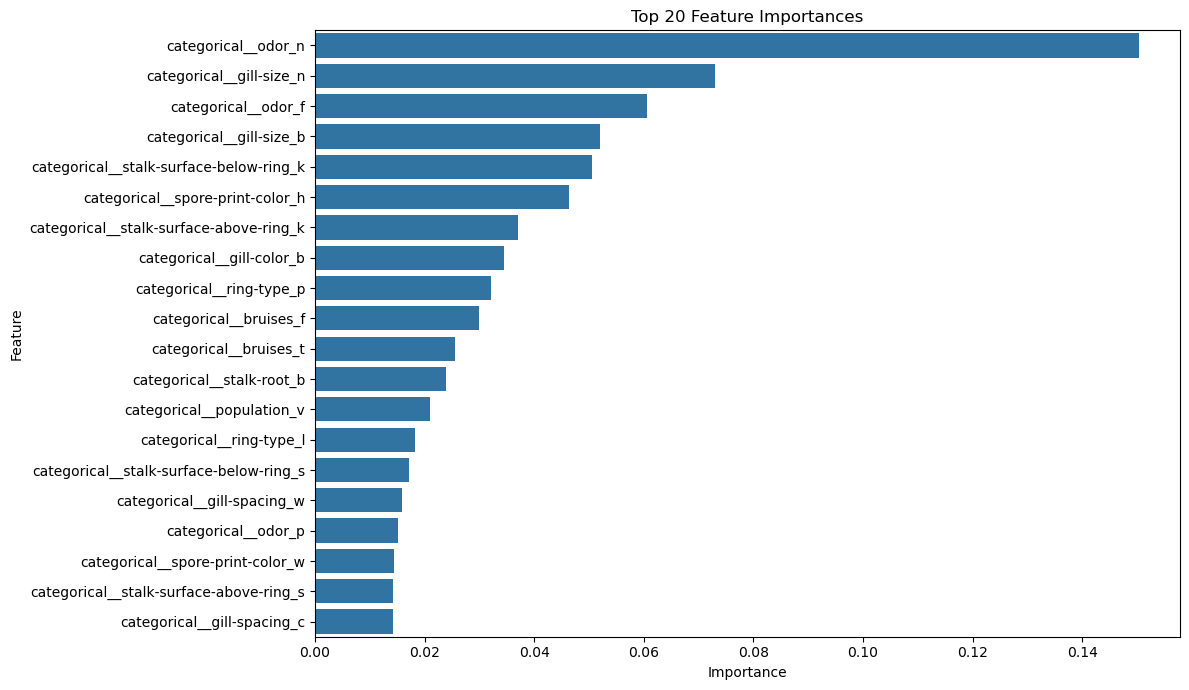

In [39]:

# Get the best estimator from GridSearchCV
best_classifier = grid_search.best_estimator_['classifier']
preprocessor = grid_search.best_estimator_['preprocessor']

# Get feature names after one-hot encoding
# The preprocessor creates a transformer that has 'get_feature_names_out'
# We need to correctly call it on the transformed data
encoded_feature_names = preprocessor.get_feature_names_out(X_train.columns)

# Get feature importances
if hasattr(best_classifier, 'feature_importances_'):
    importances = best_classifier.feature_importances_
    feature_importances = pd.DataFrame({'feature': encoded_feature_names, 'importance': importances})
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    print("Top 10 Feature Importances:")
    print(feature_importances.head(10))

    # Plot feature importances
    plt.figure(figsize=(12, 7))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("The best classifier does not have feature_importances_ attribute.")

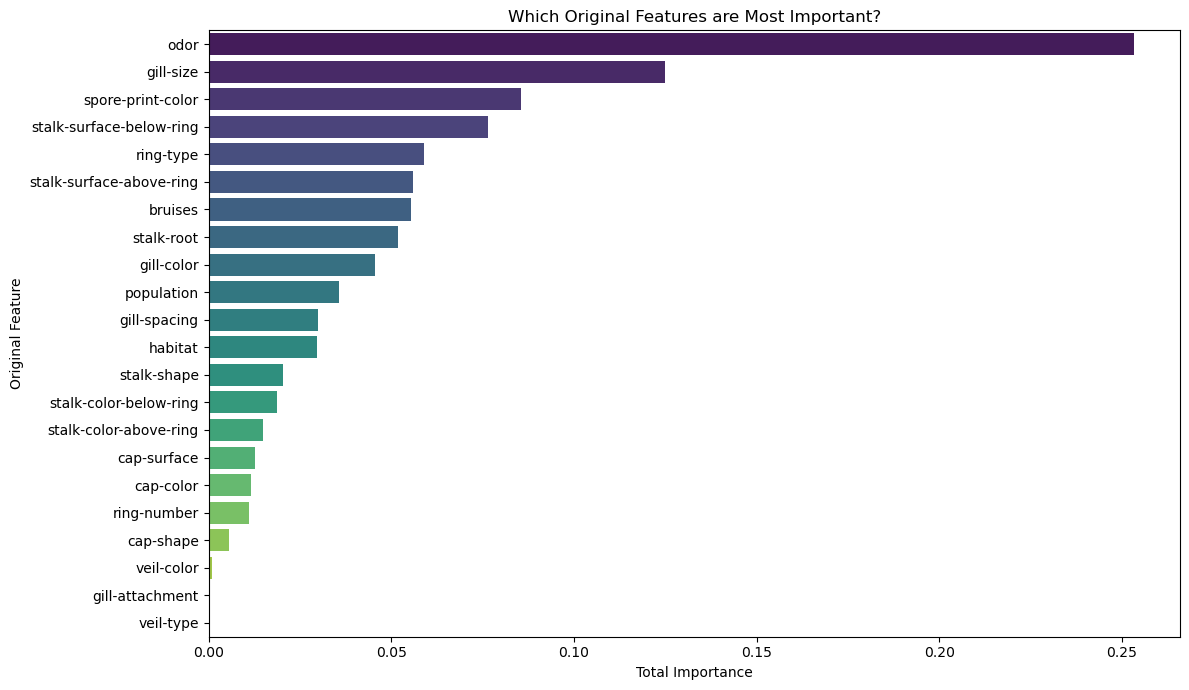

In [40]:
# This cell should be placed after the feature importance calculation cell.
# It assumes the 'feature_importances' DataFrame is already created.

if 'feature_importances' in locals():
    # Extract the original feature name from the one-hot encoded name
    # e.g., 'categorical__odor_f' becomes 'odor'
    #feature_importances['original_feature'] = feature_importances['feature'].apply(lambda x: x.split('__')[1].rsplit('_', 1)[0])
    feature_importances['original_feature'] = feature_importances['feature'].apply(lambda x: x.split('__')[1].rsplit('_', 1)[0] if '__' in x else x)

    # Group by the original feature and sum the importances
    aggregated_importances = feature_importances.groupby('original_feature')['importance'].sum().sort_values(ascending=False)

    # Create a DataFrame for plotting
    aggregated_importances_df = aggregated_importances.reset_index()

    # Plot the aggregated feature importances
    plt.figure(figsize=(12, 7))
    sns.barplot(x='importance', y='original_feature', data=aggregated_importances_df, palette='viridis')
    plt.title('Which Original Features are Most Important?')
    plt.xlabel('Total Importance')
    plt.ylabel('Original Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Run the previous feature importance cell first.")

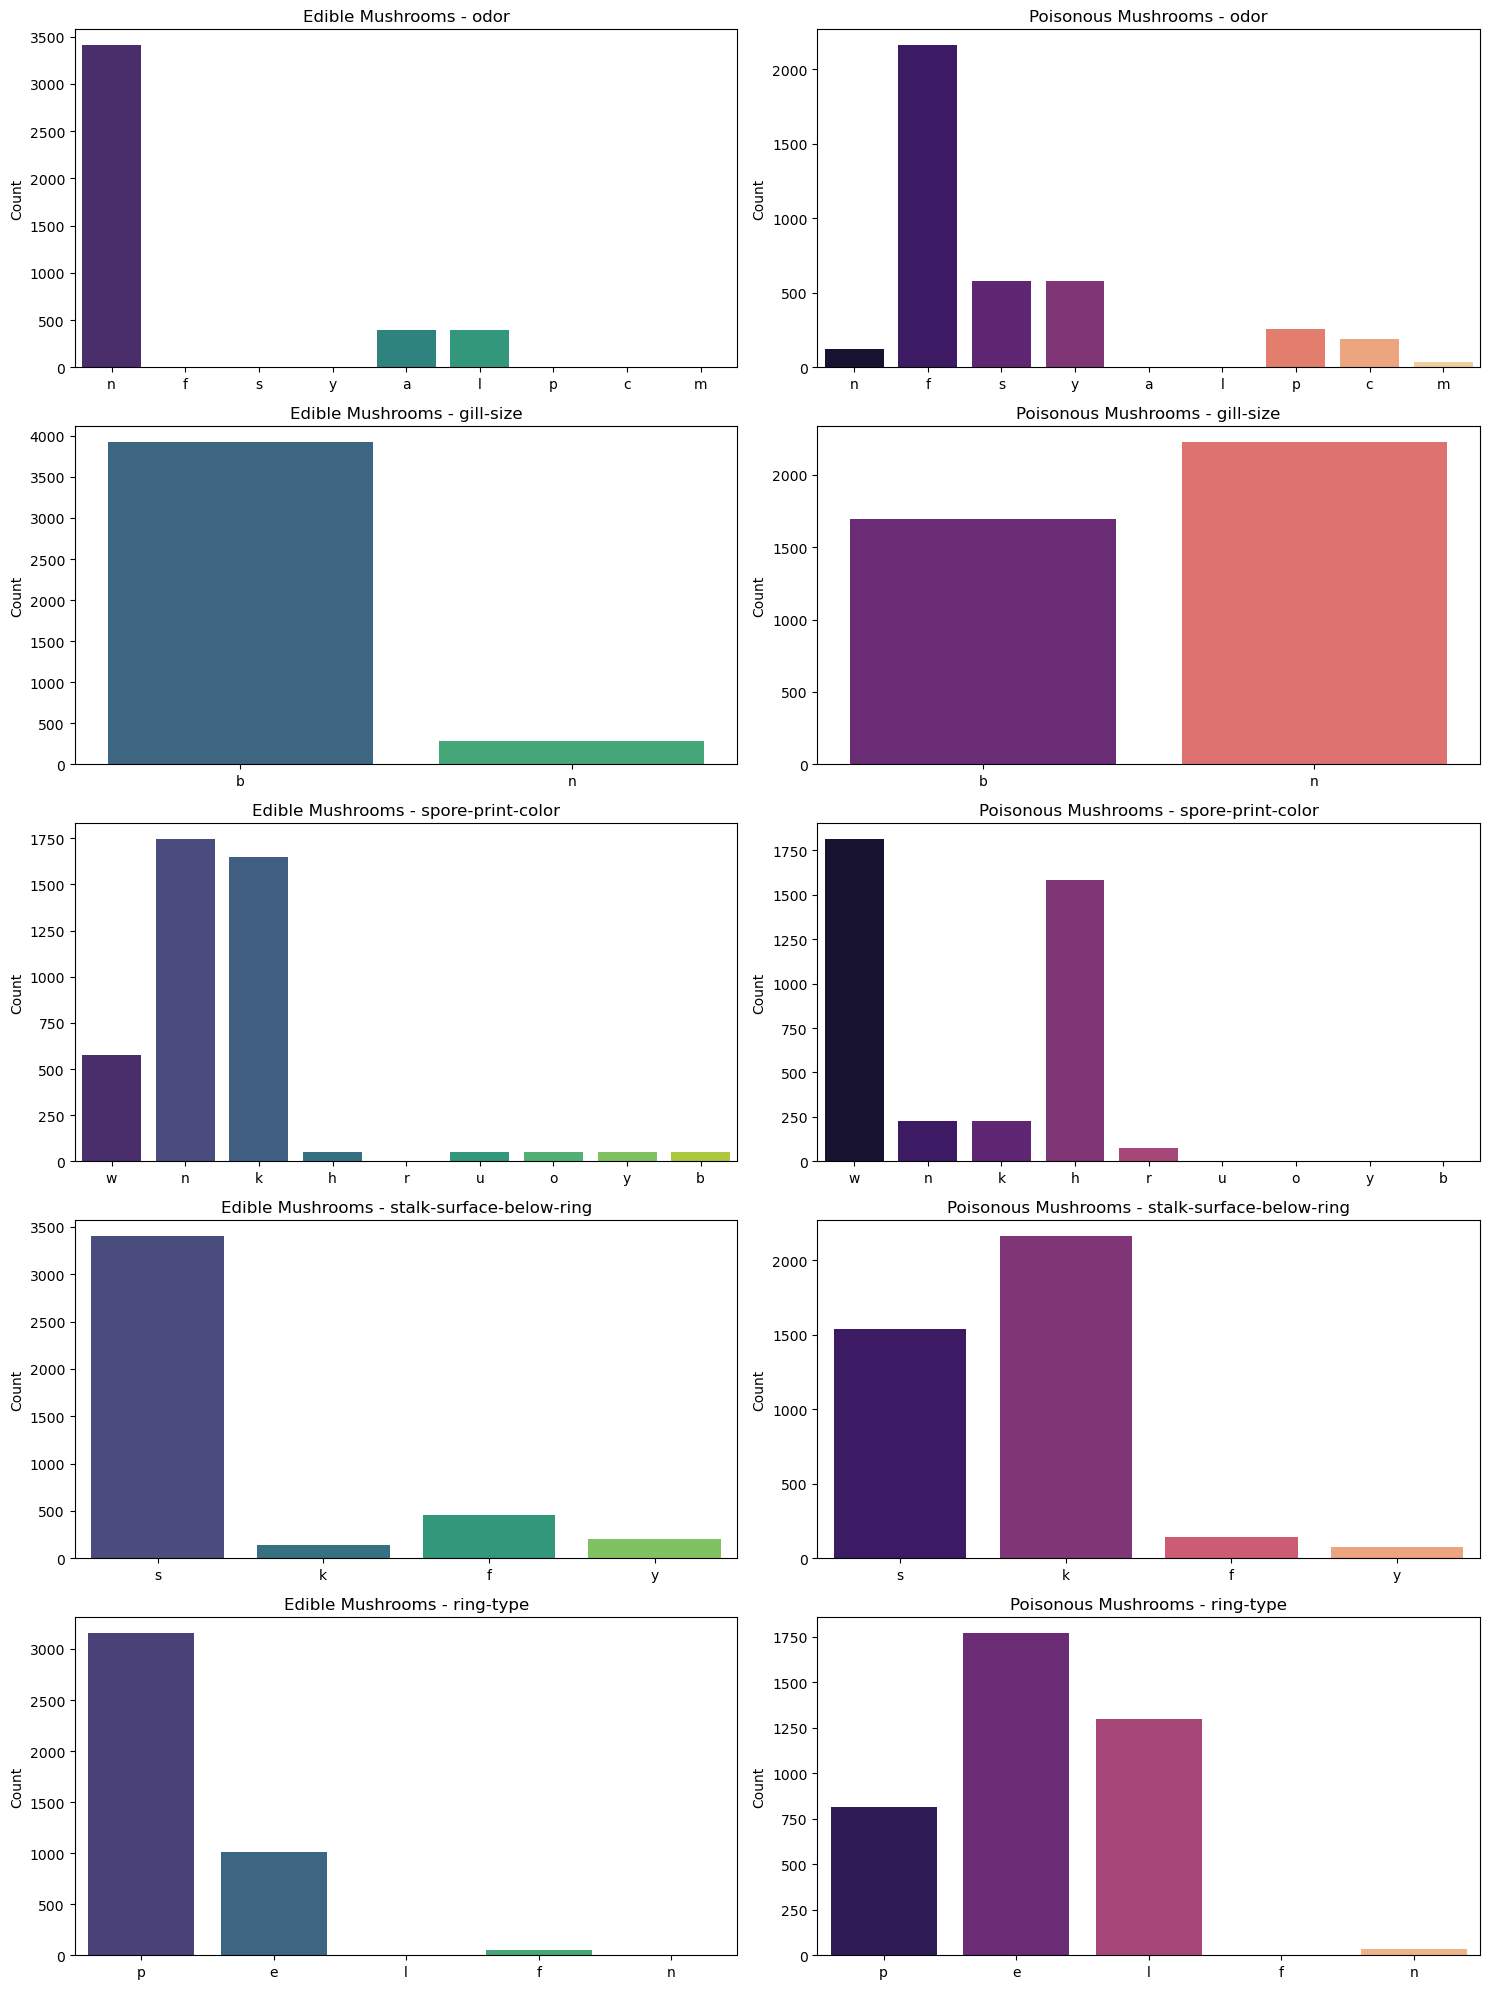

In [57]:
# Looking at top n original features from feature importance
n_features = 5

# Extract the original feature names from the feature_importances
#top_original_features = feature_importances['original_feature'].unique()[:n_features]
top_original_features = aggregated_importances_df['original_feature'][:n_features]
# Plot countplots for the top original features, separated by 'class'
plt.figure(figsize=(15, len(top_original_features) * 4))
for i, feature in enumerate(top_original_features):
    plt.subplot(len(top_original_features), 2, 2*i + 1) # Create subplot for 'edible'
    sns.countplot(data=mushroom[mushroom['class'] == 'e'], x=feature, order=mushroom[feature].value_counts().index, palette='viridis')
    plt.title(f'Edible Mushrooms - {feature}')
    plt.xlabel('')
    plt.ylabel('Count')

    plt.subplot(len(top_original_features), 2, 2*i + 2) # Create subplot for 'poisonous'
    sns.countplot(data=mushroom[mushroom['class'] == 'p'], x=feature, order=mushroom[feature].value_counts().index, palette='magma')
    plt.title(f'Poisonous Mushrooms - {feature}')
    plt.xlabel('')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


Let's visualize the relationship between `odor` and `gill-size`, broken down by the mushroom's `class`. This will help us understand if certain combinations of these features are more indicative of edibility or poisonousness.

## โดยเฉพาะ 2 ตัวนี้ที่แยกกันชัด

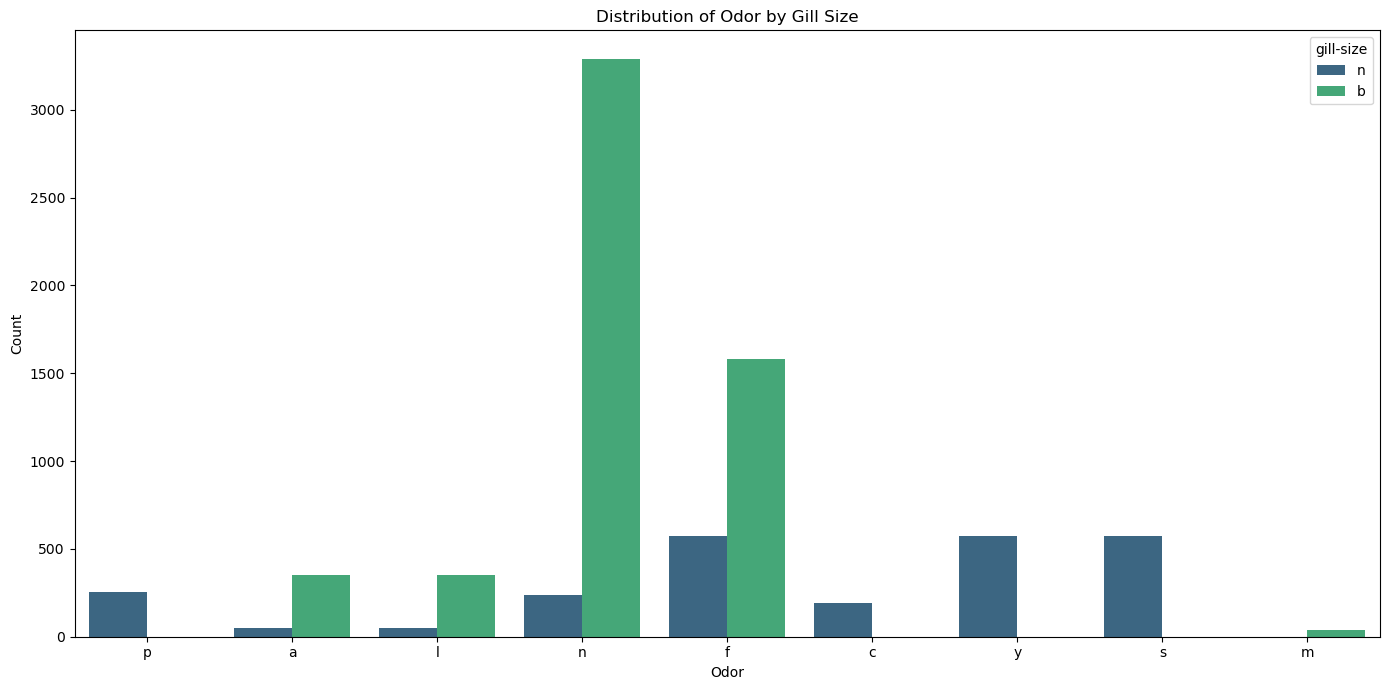

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.countplot(data=mushroom, x='odor', hue='gill-size', palette='viridis')
plt.title('Distribution of Odor by Gill Size')
plt.xlabel('Odor')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

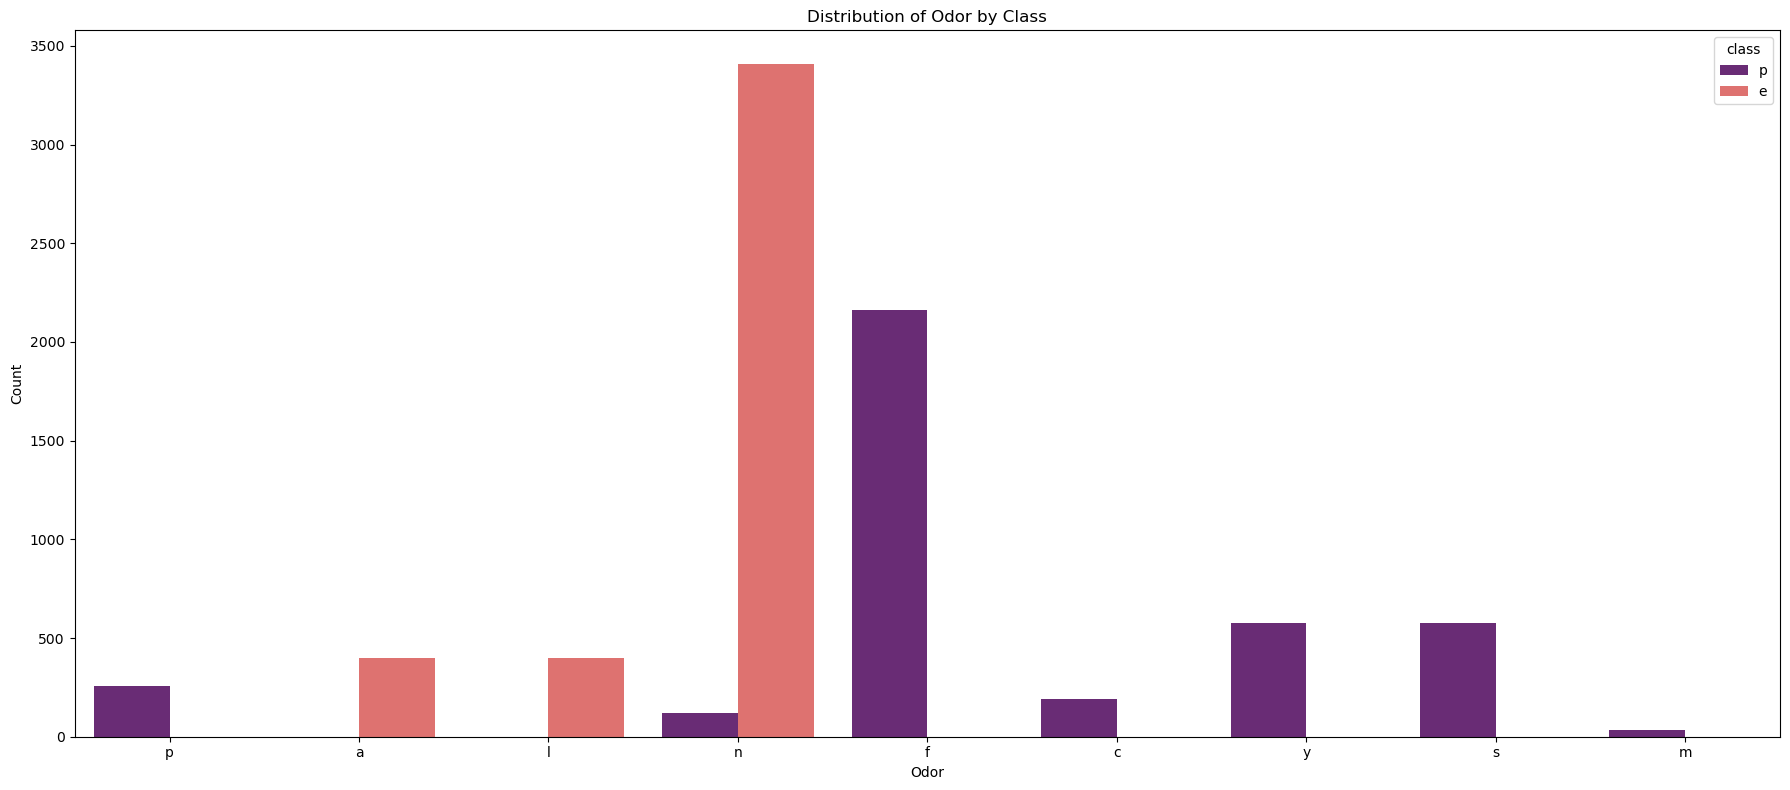

In [43]:
plt.figure(figsize=(18, 8))
sns.countplot(data=mushroom, x='odor', hue='class', palette='magma')
plt.title('Distribution of Odor by Class')
plt.xlabel('Odor')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

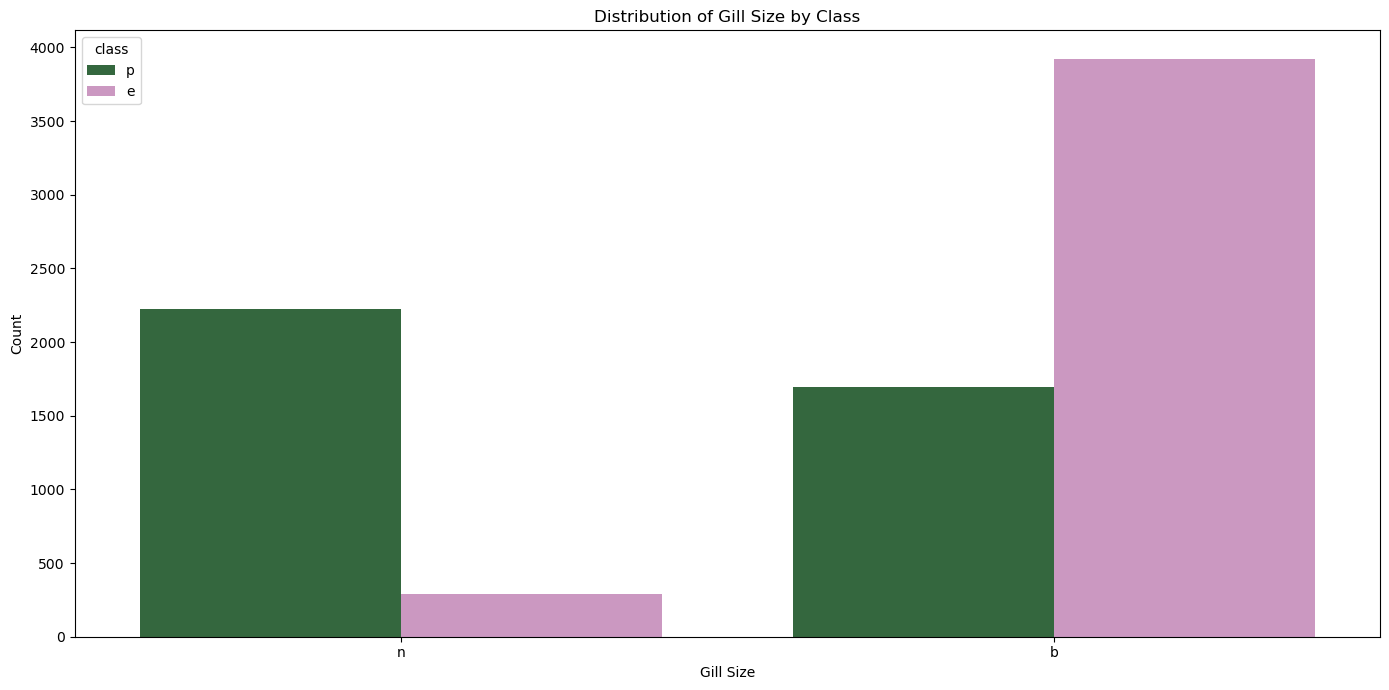

In [44]:
plt.figure(figsize=(14, 7))
sns.countplot(data=mushroom, x='gill-size', hue='class', palette='cubehelix')
plt.title('Distribution of Gill Size by Class')
plt.xlabel('Gill Size')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## อันนี้ไม่น่าใส่ / ใส่ขำ ๆ ในสไลด์

['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


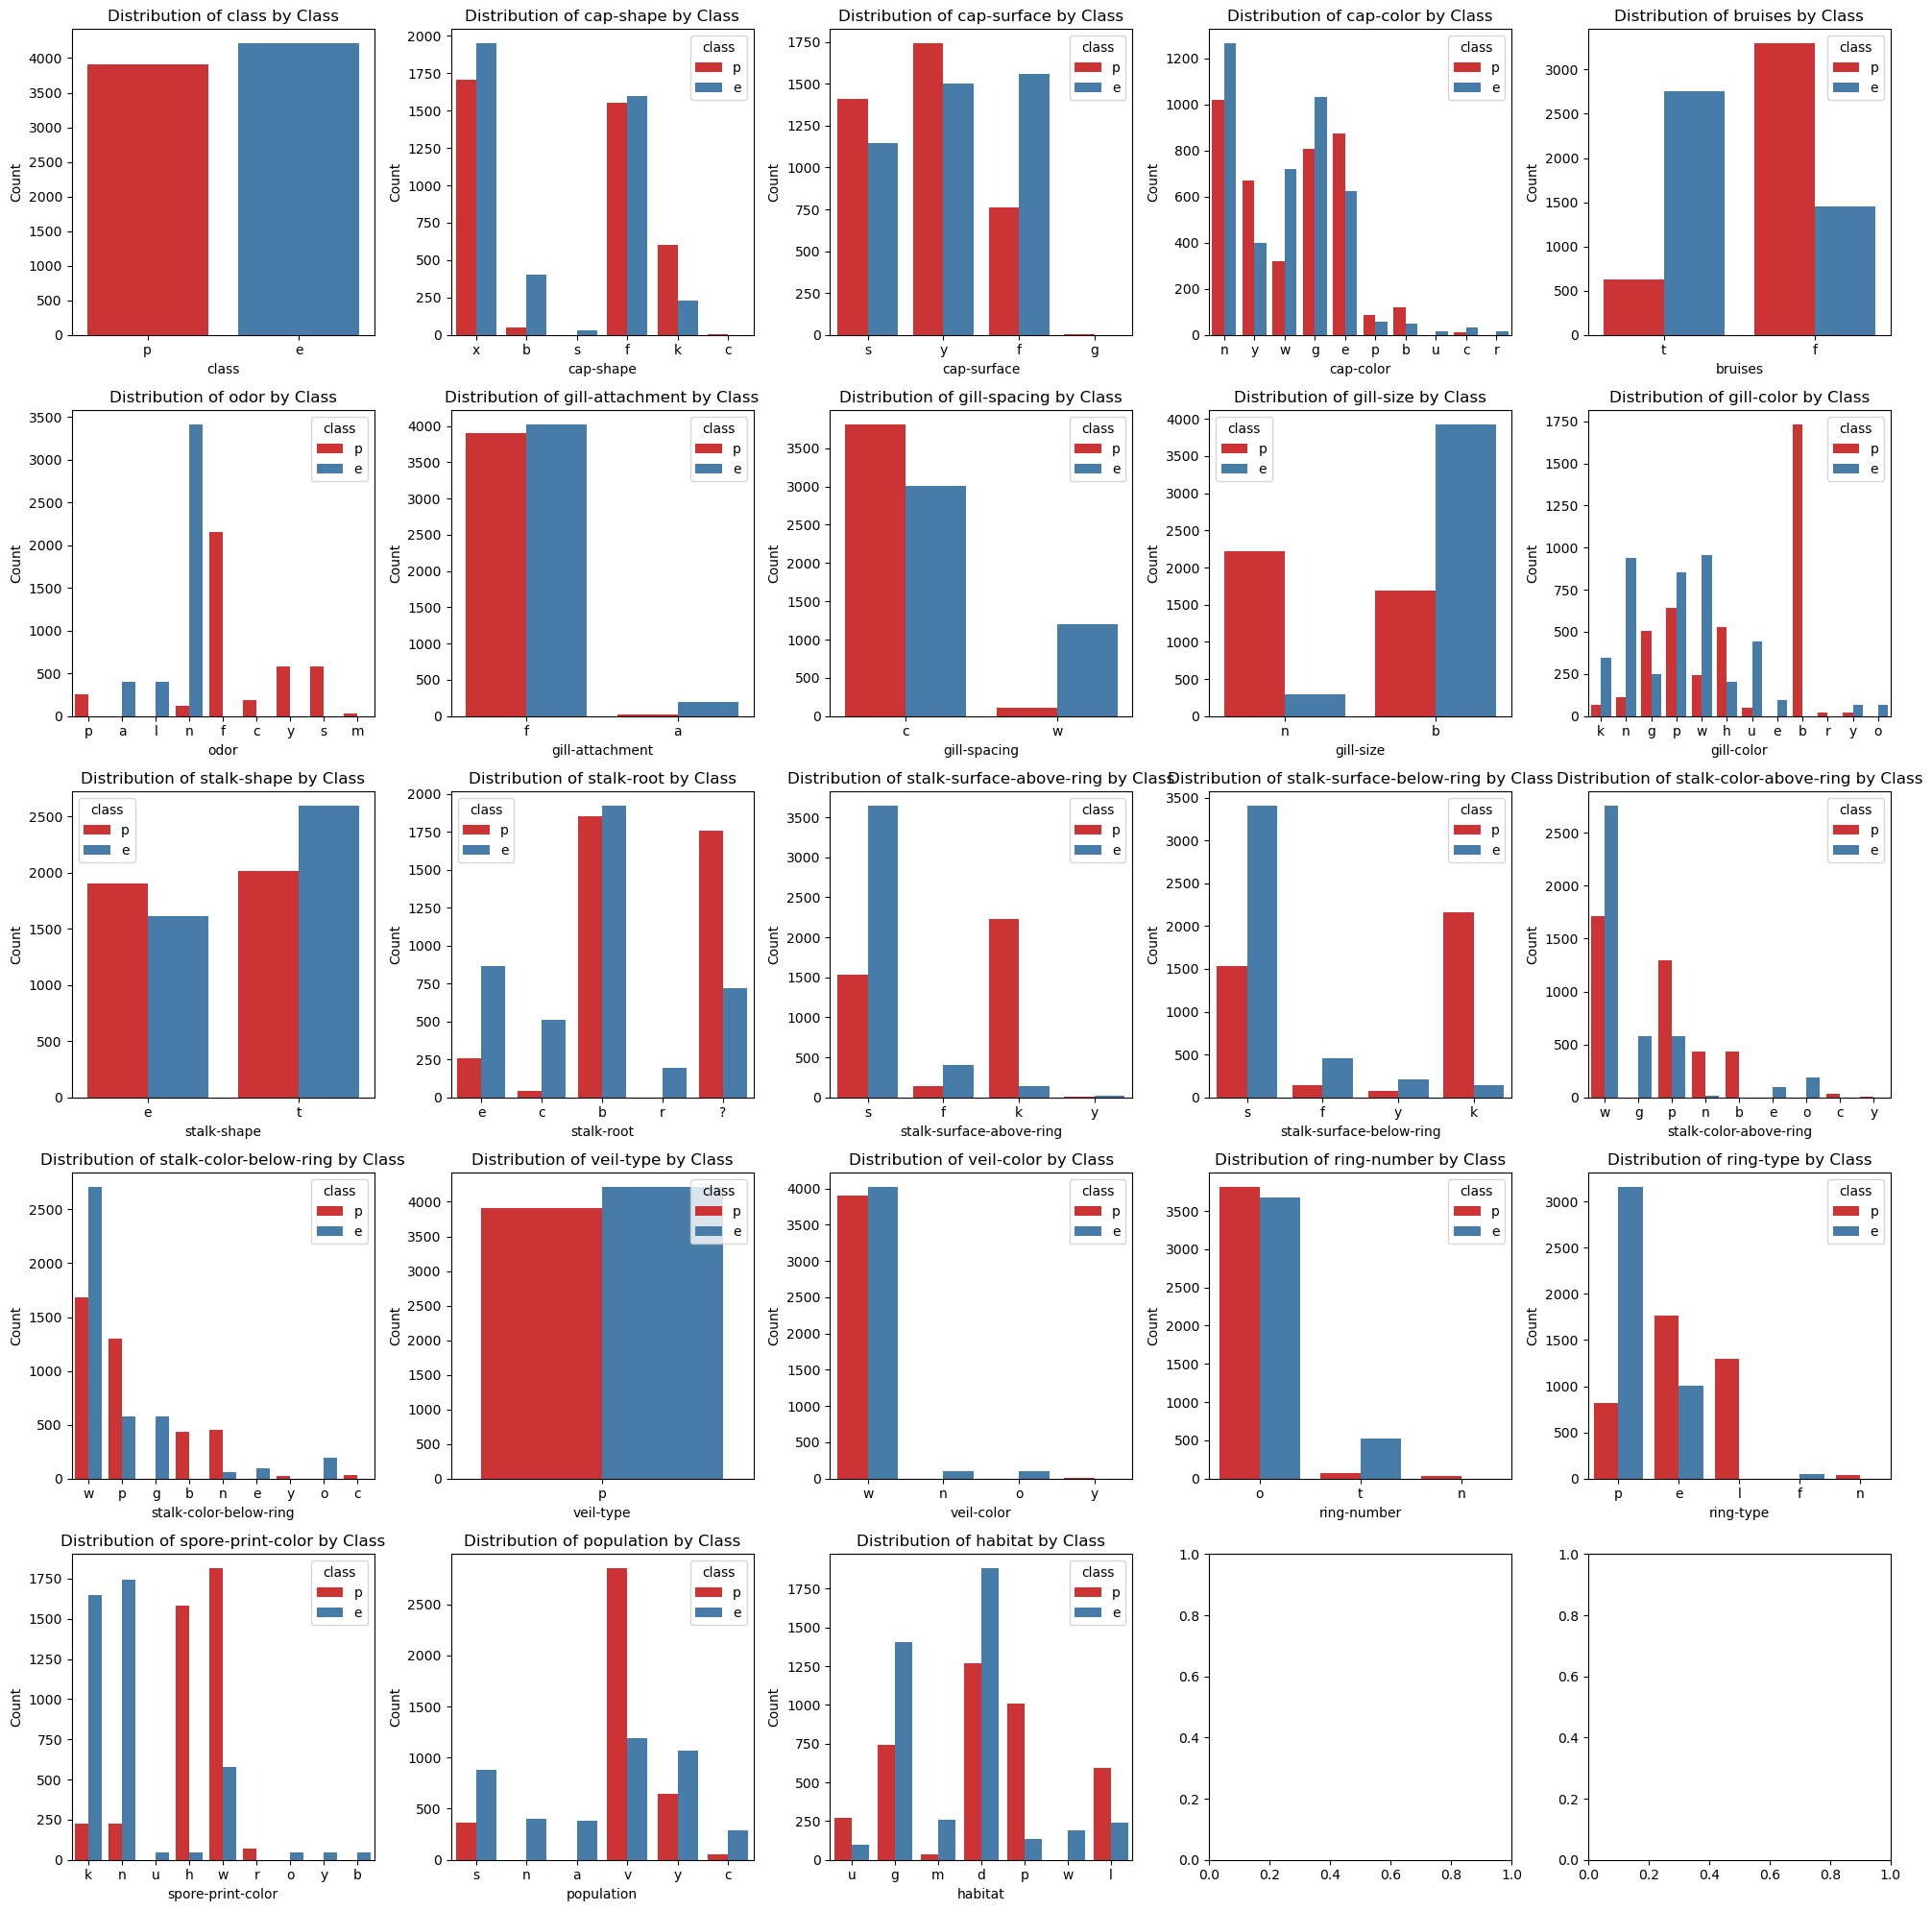

In [45]:
# Count plot for each category
fig,axes=plt.subplots(5,5,figsize=(20,20))
print(categorical_cols)
for i, col in enumerate(categorical_cols):
    sns.countplot(data=mushroom, x=col, hue='class', ax=axes[i//5, i%5], palette='Set1')
    axes[i//5, i%5].set_title(f'Distribution of {col} by Class')
    axes[i//5, i%5].set_xlabel(col)
    axes[i//5, i%5].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [46]:
# TODO: try PCA or t-SNE for visualization of high-dimensional data (whatever that means)
# TODO 
# use Secondary mushroom dataset for more performance validation


# Experiment on the Secondary Mushroom dataset

In [47]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
secondary_mushroom = fetch_ucirepo(id=848) 
  
# data (as pandas dataframes) 
secondary_X = secondary_mushroom.data.features 
secondary_y = secondary_mushroom.data.targets 
  
# metadata 
print(secondary_mushroom.metadata) 
  
# variable information 
print(secondary_mushroom.variables) 


{'uci_id': 848, 'name': 'Secondary Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/848/data.csv', 'abstract': 'Dataset of simulated mushrooms for binary classification into edible and poisonous.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 61068, 'num_features': 20, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2021, 'last_updated': 'Wed Apr 10 2024', 'dataset_doi': '10.24432/C5FP5Q', 'creators': ['Dennis Wagner', 'D. Heider', 'Georges Hattab'], 'intro_paper': {'ID': 259, 'type': 'NATIVE', 'title': 'Mushroom data creation, curation, and simulation to support classification tasks', 'authors': 'Dennis Wagner, D. Heider, Georges Hattab', 'venue': 'Scientific Reports', 'year': 2021, 'journal': None, '

In [48]:
secondary_X.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


In [49]:
secondaty_grid_search = GridSearchCV(pipe, param_grid, cv=8, scoring='accuracy', n_jobs=-1)